In [49]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten

from datetime import datetime

from collections import defaultdict

import sentencepiece

from transformers import BertTokenizer, TFBertModel

from transformers import AutoTokenizer, AutoModel, AutoModelForPreTraining, TFAutoModel

In [50]:
tf.get_logger().setLevel("ERROR") 

In [51]:
path = '../data/sample'
filename = 'sample_ner.csv'
full_path = f'{path}/{filename}'

In [52]:
full_path

'../data/sample/sample_ner.csv'

#### Exploring the tokenizer

In [53]:
tokenizer = AutoTokenizer.from_pretrained("giacomomiolo/scibert_reupload")

In [79]:
encoded_input = tokenizer("Example 194 3-Isobutyl-5-methyl-1-(oxetan-2-ylmethyl)-6-[(2-oxoimidazolidin-1-yl)methyl]thieno[2,3-d]pyrimidine-2,4(1H,3H)-dione (racemate)") #, max_length=None, padding='max_length', truncation=True)
encoded_input

{'input_ids': [102, 1143, 11209, 239, 579, 5682, 20583, 579, 305, 579, 6090, 579, 158, 579, 145, 1502, 7972, 30111, 579, 170, 579, 18209, 7085, 546, 579, 370, 579, 260, 145, 170, 579, 1502, 13532, 4858, 11597, 9269, 579, 158, 579, 18209, 546, 6090, 1901, 8654, 13205, 260, 170, 422, 239, 579, 128, 1901, 6204, 26996, 579, 170, 422, 286, 145, 158, 30117, 422, 239, 30117, 546, 579, 346, 574, 145, 8514, 4788, 30107, 546, 103], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [80]:
len(encoded_input['input_ids'])

74

In [55]:
tokenizer.decode(encoded_input["input_ids"])

'[CLS] example 194 3 - isobutyl - 5 - methyl - 1 - ( oxetan - [SEP]'

In [56]:
tokenizer.tokenize('evaporator')

['evapor', '##ator']

#### Generate NER label list

In [57]:
def addWord(word, ner):
    """
    Convert a word into a word token and add supplied NER labels. 
    Note that the word can be tokenized to two or more tokens. 
    Correspondingly, we add - for now - custom 'X' tokens to the labels 
    in order to maintain the 1:1 mappings between word tokens and labels.
    
    arguments: word, ner label
    returns: dictionary with tokens and labels
    
    *Function modified from BERT_T5_NER_2_3_030521
    """
    
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponding to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['nerToken'] = [ner] + ['nerX'] * (tokenLength - 1)
    addDict['tokenLength'] = tokenLength
    
    return addDict

In [58]:
def generate_bert_ner_inputs(full_path, max_length=400):
    """
    Read the file line by line and construct snippets ("sentences"). 
    A snippet end is marked by 'SNIPPET: [snippet id]' in the next row.
    
    Also, cap snippet length using max_length. 
    Snippets which are shorter than max_length are padded. 
    All snippets end with a [SEP] token, padded or not.
    
    arguments: full path of input file, max length of snippet
    returns: lists for BERT inputs (bertSentenceIDs, bertMasks, bertSequenceIDs)
             and the inputs before BERT tokenization (sentenceList, nerTokenList, sentLengthList)
    
    *Function modified from BERT_T5_NER_2_3_030521
    """

    with io.open(full_path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.readlines()


    # lists for sentences, tokens, labels, etc. 
    sentenceTokenList = []
    nerTokenList = []
    sentLengthList = []

    # lists for BERT input
    bertSentenceIDs = []
    bertMasks = []
    bertSequenceIDs = []

    # always start with [CLS] tokens
    sentenceTokens = ['[CLS]']
    nerTokens = ['[nerCLS]']

    for line in text:
        
        parsed_line = line.strip().split('\t')
        
        # if new sentence starts
        if parsed_line[0][:8] == 'SNIPPET:':
            
            if len(sentenceTokens) > 1:
            
                # figure out sentence length for padding or truncating
                sentenceLength = min(max_length -1, len(sentenceTokens))
                sentLengthList.append(sentenceLength)

                # Create space for at least a final '[SEP]' token
                if sentenceLength >= max_length - 1: 
                    sentenceTokens = sentenceTokens[:max_length - 2]
                    nerTokens = nerTokens[:max_length - 2]

                # add a ['SEP'] token and padding 
                sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length -1 - len(sentenceTokens))
                nerTokens += ['[nerSEP]'] + ['[nerPAD]'] * (max_length - 1 - len(nerTokens) )

                # append current data to lists
                sentenceTokenList.append(sentenceTokens)
                nerTokenList.append(nerTokens)

                # generate BERT tokens
                bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
                #bertSentenceIDs.append(tokenizer.prepare_seq2seq_batch(sentenceTokens, return_tensors='tf'))
                bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length -1 - sentenceLength ))
                bertSequenceIDs.append([0] * (max_length))

                # initialize new sentence
                sentenceTokens = ['[CLS]']
                nerTokens = ['[nerCLS]']
                
        elif parsed_line[0]:            
            word = parsed_line[0]
            ner = parsed_line[1]
            
            addDict = addWord(word, ner)
            sentenceTokens += addDict['wordToken']
            nerTokens += addDict['nerToken']
    
    # take care of last sentence
    # figure out sentence length for padding or truncating
    sentenceLength = min(max_length -1, len(sentenceTokens))
    sentLengthList.append(sentenceLength)

    # Create space for at least a final '[SEP]' token
    if sentenceLength >= max_length - 1: 
        sentenceTokens = sentenceTokens[:max_length - 2]
        nerTokens = nerTokens[:max_length - 2]

    # add a ['SEP'] token and padding 
    sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length -1 - len(sentenceTokens))
    nerTokens += ['[nerSEP]'] + ['[nerPAD]'] * (max_length - 1 - len(nerTokens) )

    # append current data to lists
    sentenceTokenList.append(sentenceTokens)
    nerTokenList.append(nerTokens)

    # generate BERT tokens
    bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
    bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length -1 - sentenceLength ))
    bertSequenceIDs.append([0] * (max_length))

    return sentenceTokenList, nerTokenList, sentLengthList, bertSentenceIDs, bertMasks, bertSequenceIDs

In [59]:
sentenceTokenList, nerTokenList, sentLengthList, bertSentenceIDs, bertMasks, bertSequenceIDs = generate_bert_ner_inputs(full_path)

In [60]:
len(nerTokenList)

50

#### Initial Data Analysis

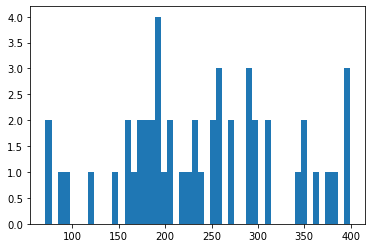

In [61]:
max_length = 400
sentenceLengths= [l for l in sentLengthList]
plt.hist(np.array(sentenceLengths), bins=(50))
pass

In [62]:
len(sentLengthList)

50

In [63]:
numSentences = len(bertSentenceIDs)

nerClasses = pd.DataFrame(np.array(nerTokenList).reshape(-1))
nerClasses.columns = ['tag']
nerClasses.tag = pd.Categorical(nerClasses.tag)
nerClasses['cat'] = nerClasses.tag.cat.codes
nerClasses['sym'] = nerClasses.tag.cat.codes
nerLabels = np.array(nerClasses.cat).reshape(numSentences, -1)

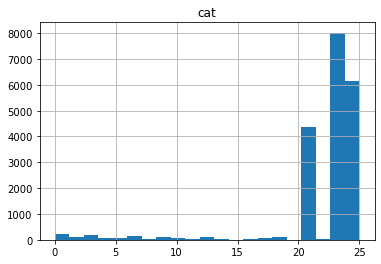

In [64]:
nerClasses[['cat']].hist(bins=21)
pass

In [65]:
nerDistribution = (nerClasses.groupby(['tag', 'cat']).agg({'sym':'count'}).reset_index()
                   .rename(columns={'sym':'occurences'}))

numNerClasses = nerDistribution.tag.nunique()

nerDistribution

,tag,cat,occurences
0,B-EXAMPLE_LABEL,0,49
1,B-EXAMPLE_LABEL,1,0
2,B-EXAMPLE_LABEL,2,0
3,B-EXAMPLE_LABEL,3,0
4,B-EXAMPLE_LABEL,4,0
...,...,...,...
671,nerX,21,0
672,nerX,22,0
673,nerX,23,0
674,nerX,24,0


In [66]:
ner_categories = nerDistribution.loc[(nerDistribution.iloc[:,1:]!=0).all(1)].reset_index()
ner_categories

,index,tag,cat,occurences
0,27,B-OTHER_COMPOUND,1,171
1,54,B-REACTION_PRODUCT,2,109
2,81,B-REACTION_STEP,3,172
3,108,B-REAGENT_CATALYST,4,58
4,135,B-SOLVENT,5,61
5,162,B-STARTING_MATERIAL,6,88
6,189,B-TEMPERATURE,7,74
7,216,B-TIME,8,47
8,243,B-WORKUP,9,120
9,270,B-YIELD_OTHER,10,55


#### Baseline: Always picking 'Other'

In [67]:
O_occurences = int(nerDistribution.loc[nerDistribution.tag == 'O','occurences']\
                                .reset_index().drop(['index'], axis=1).loc[21])   # Some gymnasics to get the count..
All_occurences = nerDistribution[nerDistribution.cat < 22]['occurences'].sum()

O_occurences/All_occurences

0.7569348127600555

#### Train/Test Split

In [68]:
bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])

In [69]:
numSentences = len(bert_inputs[0])
np.random.seed(0)
training_examples = np.random.binomial(1, 0.7, numSentences)

In [70]:
trainSentence_ids = []
trainMasks = []
trainSequence_ids = []

testSentence_ids = []
testMasks = []
testSequence_ids = []

nerLabels_train =[]
nerLabels_test = []


for example in range(numSentences):
    if training_examples[example] == 1:
        trainSentence_ids.append(bert_inputs[0][example])
        trainMasks.append(bert_inputs[1][example])
        trainSequence_ids.append(bert_inputs[2][example])
        nerLabels_train.append(nerLabels[example])
    else:
        testSentence_ids.append(bert_inputs[0][example])
        testMasks.append(bert_inputs[1][example])
        testSequence_ids.append(bert_inputs[2][example])
        nerLabels_test.append(nerLabels[example])
        
X_train = np.array([trainSentence_ids,trainMasks,trainSequence_ids])
X_test = np.array([testSentence_ids,testMasks,testSequence_ids])

nerLabels_train = np.array(nerLabels_train)
nerLabels_test = np.array(nerLabels_test)

In [71]:
# Use a parameter pair k_start, k_end to look at slices. This helps with quick tests.

k_start = 0
k_end = -1

if k_end == -1:
    k_end_train = X_train[0].shape[0]
    k_end_test = X_test[0].shape[0]
else:
    k_end_train = k_end_test = k_end
    


bert_inputs_train_k = [X_train[0][k_start:k_end_train], X_train[1][k_start:k_end_train], 
                       X_train[2][k_start:k_end_train]]
bert_inputs_test_k = [X_test[0][k_start:k_end_test], X_test[1][k_start:k_end_test], 
                      X_test[2][k_start:k_end_test]]


labels_train_k = nerLabels_train[k_start:k_end_train]
labels_test_k = nerLabels_test[k_start:k_end_test]

## The Model

#### Custom Loss & Accuracy
(from BERT_T5_NER_2_3_030521)

We need a custom loss function because we only want to optimize for the labels that we actually had in the text, not the extra ones like '[nerPAD]', etc. Our cost function is therefore derived from sparse_categorical_crossentropy, but we choose to modify the function a bit: we want to mask out all tokens that have a token id larger or equal to 22, corresponding to the extra tokens:

In [72]:
def custom_loss(y_true, y_pred):
    """
    calculate loss function explicitly, filtering out 'extra inserted labels'
    
    y_true: Shape: (batch x (max_length + 1) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns:  cost
    """

    #get labels and predictions
    
    y_label = tf.reshape(Flatten()(tf.cast(y_true, tf.int32)),[-1])
    
    mask = (y_label < 22)   # This mask is used to remove all tokens that do not correspond to the original base text.

    y_label_masked = tf.boolean_mask(y_label, mask)  # mask the labels
    
    y_flat_pred = tf.reshape(Flatten()(tf.cast(y_pred, tf.float32)),[-1, numNerClasses])
    
    y_flat_pred_masked = tf.boolean_mask(y_flat_pred, mask) # mask the predictions
    
    return tf.reduce_mean(sparse_categorical_crossentropy(y_label_masked, y_flat_pred_masked,from_logits=False ))

In [73]:
def custom_acc_orig_tokens(y_true, y_pred):
    """
    calculate loss dfunction filtering out also the newly inserted labels
    
    y_true: Shape: (batch x (max_length) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns: accuracy
    """

    #get labels and predictions
    
    y_label = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])
    
    mask = (y_label < 22)
    y_label_masked = tf.boolean_mask(y_label, mask)
    
    y_predicted = tf.math.argmax(input = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_pred, tf.float64)),\
                                                    [-1, numNerClasses]), axis=1)
    
    y_predicted_masked = tf.boolean_mask(y_predicted, mask)

    return tf.reduce_mean(tf.cast(tf.equal(y_predicted_masked,y_label_masked) , dtype=tf.float64))

In [74]:
def custom_acc_orig_non_other_tokens(y_true, y_pred):
    """
    calculate loss dfunction explicitly filtering out also the 'Other'- labels
    
    y_true: Shape: (batch x (max_length) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns: accuracy
    """

    #get labels and predictions
    
    y_label = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])
    
    mask = (y_label < 21)
    y_label_masked = tf.boolean_mask(y_label, mask)
    
    y_predicted = tf.math.argmax(input = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_pred, tf.float64)),\
                                                    [-1, numNerClasses]), axis=1)
    
    y_predicted_masked = tf.boolean_mask(y_predicted, mask)

    return tf.reduce_mean(tf.cast(tf.equal(y_predicted_masked,y_label_masked) , dtype=tf.float64))

#### Define Adam optimizer

In [75]:
adam_customized = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.91, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

#### Model Construction

In [76]:
def ner_model(max_input_length, train_layers, optimizer):
    """
    Implementation of NER model
    
    variables:
        max_input_length: number of tokens (max_length + 1)
        train_layers: number of layers to be retrained
        optimizer: optimizer to be used
    
    returns: model
    """
    
    in_id = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="segment_ids")
    
    
    bert_inputs = [in_id, in_mask, in_segment]
    
    
    
    # Note: Bert layer from Hugging Face returns two values: sequence ouput, and pooled output. Here, we only want
    # the former. (See https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel) 
    
    bert_layer = TFAutoModel.from_pretrained("giacomomiolo/scibert_reupload")
    
    # Freeze layers, i.e. only train number of layers specified, starting from the top
    
#     if not train_layers == -1:
        
#         retrain_layers = []
    
#         for retrain_layer_number in range(train_layers):

#             layer_code = '_' + str(11 - retrain_layer_number)
#             retrain_layers.append(layer_code)

#         for w in bert_layer.weights:
#             if not any([x in w.name for x in retrain_layers]):
#                 w._trainable = False

        # End of freezing section
    
    bert_sequence = bert_layer(bert_inputs)[0]
    
    print('Let us check the shape of the BERT layer output:', bert_sequence)
    
    dense = tf.keras.layers.Dense(256, activation='relu', name='dense')(bert_sequence)
    
    dense = tf.keras.layers.Dropout(rate=0.1)(dense)
    
    pred = tf.keras.layers.Dense(26, activation='softmax', name='ner')(dense)
     
    print('pred: ', pred)
    
    ## Prepare for multipe loss functions, although not used here
    
    losses = {
        "ner": custom_loss,
        }
    lossWeights = {"ner": 1.0
                  }
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)

    model.compile(loss=losses, optimizer=optimizer, metrics=[custom_acc_orig_tokens, 
                                                          custom_acc_orig_non_other_tokens])
    
    
    model.summary()
    
    return model

#### Training BERT

In [77]:
tf.keras.backend.clear_session()

In [78]:
model = ner_model(max_length + 1,train_layers=0,optimizer='adam')

# Instantiate variables

model.fit(
    bert_inputs_train_k, 
    {"ner": labels_train_k },
    validation_data=(bert_inputs_test_k, {"ner": labels_test_k}),
    epochs=8,
    batch_size=32
)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at giacomomiolo/scibert_reupload.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Let us check the shape of the BERT layer output: KerasTensor(type_spec=TensorSpec(shape=(None, 400, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0', description="created by layer 'tf_bert_model'")
pred:  KerasTensor(type_spec=TensorSpec(shape=(None, 400, 26), dtype=tf.float32, name=None), name='ner/Softmax:0', description="created by layer 'ner'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 400)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 400)]        0                                            
________________________________________________________________________